In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
tf.__version__

'2.1.0'

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

In [4]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [6]:
BATCH_SIZE = 16
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 8
HIDDEN_DIM = 32

END_TOKEN = 0
MAX_TIME = 1024

## Create original SeqGan

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')


def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=11):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
    embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(hidden_dim, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)

    logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
    
    generator = Model(
        inputs=i_et,
        outputs=logits)
        
    return generator

In [8]:
# Modified from: https://gist.github.com/iskandr/a874e4cf358697037d14a17020304535
def highway_layers(value, n_layers, activation="tanh", gate_bias=-3):
    dim = K.int_shape(value)[-1]
    gate_bias_initializer = tf.keras.initializers.Constant(gate_bias)
    for i in range(n_layers):     
        gate = Dense(units=dim, bias_initializer=gate_bias_initializer, activation='sigmoid')(value)
        negated_gate = Lambda(
            lambda x: 1.0 - x,
            output_shape=(dim,))(gate)
        transformed = Dense(units=dim, activation=activation)(value)
        transformed_gated = Multiply()([gate, transformed])
        identity_gated = Multiply()([negated_gate, value])
        value = Add()([transformed_gated, identity_gated])
    return value

In [9]:
def build_D(T, event_vocab_dim, emb_dim, num_filters=100, kernel_size=4, dropout_rate=0.25):
    # Highway network
    i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type

    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_et = mask_layer(i_et)
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    embed0 = tf.squeeze(embed0, axis=2)

    conv1 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        strides=1,
        padding="valid",
        activation='relu',
        use_bias=True,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
        bias_initializer=tf.keras.initializers.Constant(value=0.1))(embed0)
    
    pooled = MaxPooling1D(pool_size=T-kernel_size+1, strides=1)(conv1)
    
    highwayed = highway_layers(pooled, n_layers=1, activation="relu", gate_bias=0)

    dropped = Dropout(rate=dropout_rate)(highwayed)
    
    prob = Dense(1, 
                 activation='sigmoid',
                 name='final',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
                 bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)

    discriminator = Model(
        inputs=i_et,
        outputs=prob)

    return discriminator

## Test initial G and D

In [ ]:
G = build_G(batch_size=BATCH_SIZE, event_vocab_dim=11, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM)

In [ ]:
seq_batch_1 = tf.cast(tf.random.uniform([BATCH_SIZE, T-1, 1], maxval=10, dtype=tf.int32)+1, tf.float32)
# seq_batch_1

In [ ]:
G(seq_batch_1)

In [ ]:
D = build_D(T=20, event_vocab_dim=11, emb_dim=32, num_filters=100, kernel_size=4, dropout_rate=0.25)

In [ ]:
D(seq_batch_1)

## Pre-Training of original SeqGAn

In [ ]:
def pretrain_discriminator(event_type_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator(event_type_batch)

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape

    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        ce_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            target_et = event_type_batch[:, i + 1, :]

            token_logits = generator(curr_state_et)

            ce_losses = tf.keras.losses.sparse_categorical_crossentropy(target_et, token_logits, from_logits=True)
            ce_loss = tf.reduce_mean(ce_losses)
            ce_loss_list.append(ce_loss)

        generator_loss = tf.reduce_mean(ce_loss_list)

    if verbose:
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [ ]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset(pos_event_type_seqs,
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [ ]:
pretrain_gen_ce_loss_history = []
pretrain_gen_metrics_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [ ]:
step = 0
OPTIMIZER = Adam(lr=1e-3)

for event_type_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    gen_ce_loss =  pretrain_generator(event_type_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_ce_loss_history.append(gen_ce_loss.numpy())

In [ ]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [ ]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

In [16]:
def rollout_from_prefix(
        G, batch_size, prefix, L=T, end_token=0, init_token=1):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = prefix
    curr_state_et = prefix[:, -1:, :]
    l_prefix = prefix.shape[1]
    
    G.reset_states()

    for _ in range(L-l_prefix):  # sequence length
        token_logits = G(curr_state_et)
        
        sampled_et = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

    return all_state_et



def generate_sequences(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    init_prefix = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    
    while N < N_gen:
        batch_state_et = rollout_from_prefix(generator, batch_size, init_prefix, T)
        batch_type_seq = batch_state_et.numpy()

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = np.concatenate([all_type_seq, batch_type_seq], axis=0)

        N += batch_size

    # convert to python list
    type_seq_list = all_type_seq[:N_gen].tolist()

    return type_seq_list

### pre-train D

In [ ]:
N_fake_D = N_real_D = N_total_G // 100

In [ ]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs = np.array(generate_sequences(N_fake_D, pretrained_generator, BATCH_SIZE, T))

In [ ]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]

In [ ]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = np.concatenate([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_labels = np.concatenate([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 10
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset(pretrain_D_et,
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [ ]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   num_filters=100,
                                   kernel_size=4,
                                   dropout_rate=0.25)

In [ ]:
step = 0
OPTIMIZER = SGD(lr=1e-3)
for event_type_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

In [ ]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [ ]:
reload_pretrained_disc = build_D(T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   num_filters=100,
                                   kernel_size=4,
                                   dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

## Seq Gan original Traning

In [17]:
def train_generator(generator, discriminator, batch_size, T, mc_size=10, verbose=False,                   
                    optimizer=Adam(lr=0.001), end_token=0, init_token=1):
    
    prefix = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    curr_state_et = prefix[:, -1:, :]
    
    with tf.GradientTape(persistent=True) as tape:                        

        gen_step_loss = []

        for _ in tqdm(range(1, T)):

            # MC rollout to the end to get final return
            rollout_returns = []
            for _ in range(mc_size):
                batch_rollout_et = rollout_from_prefix(generator, batch_size, prefix, T)
                rollout_returns.append(discriminator(batch_rollout_et))
            
            Q_avg = tf.reduce_mean(rollout_returns, axis=0)
            
            # one-step rollout to get next prefix
            token_logits = generator(prefix)        
            sampled_et = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
            sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])
            sampled_et = tf.cast(sampled_et, dtype=tf.float64)

            # stop genererating once hit end_token
            cond_end_token = tf.equal(curr_state_et, end_token)
            curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
            prefix = tf.concat([prefix, curr_state_et], axis=1)
            
            # averge loss over batch at each rollout step: -E[log_prob * Q]
            policy_gradient_loss = -tf.reduce_mean(tf.math.log(tf.nn.softmax(token_logits)) * Q_avg)
            gen_step_loss.append(policy_gradient_loss)
        
        avg_gen_loss = tf.reduce_mean(gen_step_loss)
        
        if verbose:
            print('generator loss:{}'.format(avg_gen_loss))
            print('-----------------------')

    # update generator
    generator_grads = tape.gradient(avg_gen_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return avg_gen_loss


def train_discriminator(real_data_batch, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001)):

    # data prep
    real_labels = tf.ones((batch_size, 1))        

    fake_labels = tf.zeros((batch_size, 1))    
    fake_data_batch = np.array(generate_sequences(1, generator, batch_size, T))
    
    total_data = tf.concat([fake_data_batch, real_data_batch], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)


    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator(total_data)

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))        

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss

## Start training from pretrained G and D

In [18]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
# G.load_weights(G_save_path)
G.summary()

D = build_D(T=T,
            event_vocab_dim=EVENT_VOCAB_DIM,
            emb_dim=EMB_DIM,
            num_filters=100,
            kernel_size=4,
            dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
# D.load_weights(D_save_path)
D.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(16, None, 1)]           0         
_________________________________________________________________
masking_2 (Masking)          (16, None, 1)             0         
_________________________________________________________________
embedding_2 (Embedding)      (16, None, 1, 8)          48        
_________________________________________________________________
tf_op_layer_Squeeze_2 (Tenso [(16, None, 8)]           0         
_________________________________________________________________
lstm (LSTM)                  (16, 32)                  5248      
_________________________________________________________________
dense_1 (Dense)              (16, 6)                   198       
Total params: 5,494
Trainable params: 5,494
Non-trainable params: 0
_________________________________________________________

In [19]:
N_total_G = pos_event_type_seqs.shape[0] // 20

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

train_dataset = create_dataset(pos_event_type_seqs[:N_total_G,:,:],
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []

step = 0

G_optimizer = SGD(learning_rate=1e-3)
D_optimizer = SGD(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

In [20]:
for event_type_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator(G, D, BATCH_SIZE, T, mc_size=100, verbose=True, optimizer=Adam(lr=0.001))        
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss = train_discriminator(event_type_batch, G, D, BATCH_SIZE, T, verbose=True, optimizer=Adam(lr=0.001))
        disc_loss_history.append(disc_loss.numpy())

#     # save weights every 200 steps
#     if step % 100 == 0:
#         print('Saving weights...')
#         save_path_prefix = f'/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/oracle_train_{step}'
#         save_model_weights(save_path_prefix, generator, discriminator, critic)
#         print('All Saved!')

0it [00:00, ?it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

Training Step: 1



100%|██████████| 20/20 [01:57<00:00,  5.86s/it]


generator loss:0.8984120299817666
-----------------------


1it [02:07, 127.18s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931607826259902
-----------------------
Training Step: 2



100%|██████████| 20/20 [01:51<00:00,  5.57s/it]


generator loss:0.9123065806225459
-----------------------


2it [04:08, 123.53s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932544798174098
-----------------------
Training Step: 3



100%|██████████| 20/20 [01:49<00:00,  5.48s/it]


generator loss:0.895577280695159
-----------------------


3it [06:07, 121.44s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931763983990782
-----------------------
Training Step: 4



100%|██████████| 20/20 [01:49<00:00,  5.47s/it]


generator loss:0.9122379255150193
-----------------------


4it [08:05, 120.39s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932518368053703
-----------------------
Training Step: 5



100%|██████████| 20/20 [01:48<00:00,  5.41s/it]


generator loss:0.8934243405384443
-----------------------


5it [10:03, 119.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931744415469064
-----------------------
Training Step: 6



100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


generator loss:0.9108002298668285
-----------------------


6it [11:56, 117.20s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932304570209078
-----------------------
Training Step: 7



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8930324044836955
-----------------------


7it [13:48, 115.50s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931889322134467
-----------------------
Training Step: 8



100%|██████████| 20/20 [01:44<00:00,  5.20s/it]


generator loss:0.9104671588776199
-----------------------


8it [15:41, 114.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932164587476954
-----------------------
Training Step: 9



100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


generator loss:0.8928795845091283
-----------------------


9it [17:35, 114.59s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931917157213592
-----------------------
Training Step: 10



100%|██████████| 20/20 [01:43<00:00,  5.20s/it]


generator loss:0.9097283839809449
-----------------------


10it [19:29, 114.16s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932164452084906
-----------------------
Training Step: 11



100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


generator loss:0.8932798849503791
-----------------------


11it [21:21, 113.78s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931924008433106
-----------------------
Training Step: 12



100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


generator loss:0.9103910861666261
-----------------------


12it [23:15, 113.71s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932060559505078
-----------------------
Training Step: 13



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


generator loss:0.8911041532976132
-----------------------


13it [25:08, 113.37s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931969506886555
-----------------------
Training Step: 14



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.9087680465192516
-----------------------


14it [26:59, 112.92s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932050842518204
-----------------------
Training Step: 15



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.8924617585198906
-----------------------


15it [28:50, 112.33s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931935629640266
-----------------------
Training Step: 16



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9083985542878785
-----------------------


16it [30:42, 112.14s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931997984875171
-----------------------
Training Step: 17



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8911655191528437
-----------------------


17it [32:34, 112.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931966689144797
-----------------------
Training Step: 18



100%|██████████| 20/20 [01:43<00:00,  5.15s/it]


generator loss:0.9083661592711746
-----------------------


18it [34:26, 112.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931952953533772
-----------------------
Training Step: 19



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8907577635807818
-----------------------


19it [36:18, 111.94s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932026243009731
-----------------------
Training Step: 20



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9081817069675722
-----------------------


20it [38:09, 111.83s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932020741230541
-----------------------
Training Step: 21



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8925090475145072
-----------------------


21it [40:01, 111.71s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931988220163041
-----------------------
Training Step: 22



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9074745949262532
-----------------------


22it [41:52, 111.67s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693204831783833
-----------------------
Training Step: 23



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8909994535114013
-----------------------


23it [43:43, 111.41s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931976873243682
-----------------------
Training Step: 24



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9079115675179207
-----------------------


24it [45:35, 111.43s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932054386272724
-----------------------
Training Step: 25



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8921380313486648
-----------------------


25it [47:26, 111.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931975205565969
-----------------------
Training Step: 26



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9087168090571573
-----------------------


26it [49:16, 111.14s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932013351560715
-----------------------
Training Step: 27



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8912788540984538
-----------------------


27it [51:08, 111.23s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932016855992531
-----------------------
Training Step: 28



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9082636688472412
-----------------------


28it [52:59, 111.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932008451185234
-----------------------
Training Step: 29



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8919599762927817
-----------------------


29it [54:51, 111.40s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931989580578668
-----------------------
Training Step: 30



100%|██████████| 20/20 [01:40<00:00,  5.05s/it]


generator loss:0.9079141811553534
-----------------------


30it [56:41, 110.89s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932007655551501
-----------------------
Training Step: 31



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.892356369859956
-----------------------


31it [58:31, 110.80s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931979066961862
-----------------------
Training Step: 32



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9079265936887857
-----------------------


32it [1:00:22, 110.71s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932048315803446
-----------------------
Training Step: 33



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.8905337433603797
-----------------------


33it [1:02:12, 110.70s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932048166348705
-----------------------
Training Step: 34



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9083350582399191
-----------------------


34it [1:04:04, 110.81s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931980689742868
-----------------------
Training Step: 35



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8917925514093357
-----------------------


35it [1:05:55, 111.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931980743092081
-----------------------
Training Step: 36



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9069407329309531
-----------------------


36it [1:07:46, 110.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931989777201479
-----------------------
Training Step: 37



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8916812657443025
-----------------------


37it [1:09:37, 111.15s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932094300195548
-----------------------
Training Step: 38



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9074830123582229
-----------------------


38it [1:11:28, 111.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932059348367072
-----------------------
Training Step: 39



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8920550637180428
-----------------------


39it [1:13:18, 110.76s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931920199893581
-----------------------
Training Step: 40



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9076403076870608
-----------------------


40it [1:15:09, 110.67s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931940839904881
-----------------------
Training Step: 41



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8920099586682486
-----------------------


41it [1:16:59, 110.40s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693195695995967
-----------------------
Training Step: 42



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9078381202844248
-----------------------


42it [1:18:49, 110.56s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693196254771778
-----------------------
Training Step: 43



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8920686188545426
-----------------------


43it [1:20:39, 110.37s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931967422922686
-----------------------
Training Step: 44



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9070187966259085
-----------------------


44it [1:22:29, 110.23s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932011812423954
-----------------------
Training Step: 45



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8913472442052083
-----------------------


45it [1:24:20, 110.28s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931970477701985
-----------------------
Training Step: 46



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9076857165013485
-----------------------


46it [1:26:09, 110.06s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931978971818893
-----------------------
Training Step: 47



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8905161021868748
-----------------------


47it [1:28:00, 110.17s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931990540652455
-----------------------
Training Step: 48



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.9075180889823418
-----------------------


48it [1:29:51, 110.47s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931958875612932
-----------------------
Training Step: 49



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8907329642058055
-----------------------


49it [1:31:41, 110.28s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931962045594042
-----------------------
Training Step: 50



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9076781719566084
-----------------------


50it [1:33:32, 110.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931977873703212
-----------------------
Training Step: 51



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8903359687751324
-----------------------


51it [1:35:22, 110.45s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693194436371558
-----------------------
Training Step: 52



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.906596007730774
-----------------------


52it [1:37:13, 110.54s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693196705986081
-----------------------
Training Step: 53



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8910770748770066
-----------------------


53it [1:39:03, 110.52s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931976629841944
-----------------------
Training Step: 54



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9070097645214155
-----------------------


54it [1:40:53, 110.32s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931948365170336
-----------------------
Training Step: 55



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8908816289134374
-----------------------


55it [1:42:44, 110.37s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693198522007696
-----------------------
Training Step: 56



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9076465509695509
-----------------------


56it [1:44:34, 110.45s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931954541531138
-----------------------
Training Step: 57



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8906287998908254
-----------------------


57it [1:46:25, 110.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931977381735861
-----------------------
Training Step: 58



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9070942047212721
-----------------------


58it [1:48:15, 110.54s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931979311822145
-----------------------
Training Step: 59



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8913948465010643
-----------------------


59it [1:50:06, 110.51s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932004359934035
-----------------------
Training Step: 60



100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


generator loss:0.9070562114779801
-----------------------


60it [1:51:58, 110.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931891464679183
-----------------------
Training Step: 61



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


generator loss:0.8910580131547048
-----------------------


61it [1:53:50, 111.27s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931918593759842
-----------------------
Training Step: 62



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9061224507152206
-----------------------


62it [1:55:41, 111.16s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931981008206667
-----------------------
Training Step: 63



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.8913400659677462
-----------------------


63it [1:57:31, 110.98s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931981533513772
-----------------------
Training Step: 64



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9075883896570591
-----------------------


64it [1:59:22, 110.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931998177404469
-----------------------
Training Step: 65



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8913752256948031
-----------------------


65it [2:01:12, 110.60s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931966118183185
-----------------------
Training Step: 66



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9067860971875017
-----------------------


66it [2:03:02, 110.47s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931940877372184
-----------------------
Training Step: 67



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8912242174254267
-----------------------


67it [2:04:52, 110.43s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931959359063314
-----------------------
Training Step: 68



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9075444664642971
-----------------------


68it [2:06:42, 110.23s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931980385996641
-----------------------
Training Step: 69



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.8917598294186526
-----------------------


69it [2:08:32, 110.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931952602974936
-----------------------
Training Step: 70



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.907294192108693
-----------------------


70it [2:10:22, 110.25s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932003788758248
-----------------------
Training Step: 71



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8906429900798057
-----------------------


71it [2:12:13, 110.34s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931956220777312
-----------------------
Training Step: 72



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9071328088411897
-----------------------


72it [2:14:04, 110.50s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931948709203704
-----------------------
Training Step: 73



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8912329212118966
-----------------------


73it [2:15:54, 110.39s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931948944290103
-----------------------
Training Step: 74



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9065698118204623
-----------------------


74it [2:17:44, 110.38s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932002792851891
-----------------------
Training Step: 75



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8915762637098874
-----------------------


75it [2:19:36, 110.71s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931985652317189
-----------------------
Training Step: 76



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9071269744048639
-----------------------


76it [2:21:26, 110.66s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931903953222011
-----------------------
Training Step: 77



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8921985174170391
-----------------------


77it [2:23:18, 110.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931959875593259
-----------------------
Training Step: 78



100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


generator loss:0.9077657800959014
-----------------------


78it [2:25:10, 111.33s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931958688734213
-----------------------
Training Step: 79



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8904037698602497
-----------------------


79it [2:27:02, 111.42s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931927554995371
-----------------------
Training Step: 80



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.907244257608045
-----------------------


80it [2:28:53, 111.26s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693196653547235
-----------------------
Training Step: 81



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.8906370853800876
-----------------------


81it [2:30:43, 111.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931927696527295
-----------------------
Training Step: 82



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.906693126705551
-----------------------


82it [2:32:34, 110.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931964791124253
-----------------------
Training Step: 83



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8912675266481397
-----------------------


83it [2:34:25, 110.85s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931984903476704
-----------------------
Training Step: 84



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9072579711831498
-----------------------


84it [2:36:15, 110.81s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931968625290297
-----------------------
Training Step: 85



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.891314638872092
-----------------------


85it [2:38:06, 110.75s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932031138104825
-----------------------
Training Step: 86



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9068728086929434
-----------------------


86it [2:39:56, 110.65s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932009288426474
-----------------------
Training Step: 87



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8915568238699902
-----------------------


87it [2:41:46, 110.43s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931921720493923
-----------------------
Training Step: 88



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9060305418614935
-----------------------


88it [2:43:36, 110.29s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931941259877301
-----------------------
Training Step: 89



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8915708920960913
-----------------------


89it [2:45:27, 110.29s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931920065751364
-----------------------
Training Step: 90



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9070680282789013
-----------------------


90it [2:47:17, 110.19s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931919034178942
-----------------------
Training Step: 91



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8910831587853171
-----------------------


91it [2:49:08, 110.56s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931903797067471
-----------------------
Training Step: 92



100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


generator loss:0.9074144225924835
-----------------------


92it [2:51:01, 111.24s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931992780549704
-----------------------
Training Step: 93



100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


generator loss:0.8897983471105686
-----------------------


93it [2:52:53, 111.40s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931952723496219
-----------------------
Training Step: 94



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.9055500151604366
-----------------------


94it [2:54:44, 111.42s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931943335245209
-----------------------
Training Step: 95



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8904972146122463
-----------------------


95it [2:56:34, 111.04s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931941453564309
-----------------------
Training Step: 96



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.906661010259946
-----------------------


96it [2:58:25, 110.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931955760616597
-----------------------
Training Step: 97



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.89190952903281
-----------------------


97it [3:00:15, 110.61s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931958905444637
-----------------------
Training Step: 98



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9069959863729732
-----------------------


98it [3:02:04, 110.32s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.69319641467117
-----------------------
Training Step: 99



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8907567010887597
-----------------------


99it [3:03:55, 110.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931950999348051
-----------------------
Training Step: 100



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9067064654526618
-----------------------


100it [3:05:45, 110.43s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931916907753566
-----------------------
Training Step: 101



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.891039965560745
-----------------------


101it [3:07:36, 110.50s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693194923731839
-----------------------
Training Step: 102



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9070760852199236
-----------------------


102it [3:09:26, 110.44s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693196494438277
-----------------------
Training Step: 103



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8912193336815453
-----------------------


103it [3:11:18, 110.72s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931917587784756
-----------------------
Training Step: 104



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9066278049837783
-----------------------


104it [3:13:07, 110.42s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931968344665362
-----------------------
Training Step: 105



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8906779988676256
-----------------------


105it [3:14:57, 110.26s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931949202296719
-----------------------
Training Step: 106



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9073250437583251
-----------------------


106it [3:16:48, 110.28s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931922837326292
-----------------------
Training Step: 107



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8902132074808555
-----------------------


107it [3:18:37, 109.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931950084906321
-----------------------
Training Step: 108



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9066686795624648
-----------------------


108it [3:20:27, 109.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931993297584722
-----------------------
Training Step: 109



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8916944126101164
-----------------------


109it [3:22:16, 109.87s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693189057168139
-----------------------
Training Step: 110



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9064361464593927
-----------------------


110it [3:24:06, 109.67s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693193720448406
-----------------------
Training Step: 111



100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


generator loss:0.8909554830431763
-----------------------


111it [3:25:55, 109.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931883483232323
-----------------------
Training Step: 112



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9065632872244784
-----------------------


112it [3:27:44, 109.56s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931911288693855
-----------------------
Training Step: 113



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.891076183434205
-----------------------


113it [3:29:34, 109.61s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6932003644833662
-----------------------
Training Step: 114



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9061419173031993
-----------------------


114it [3:31:24, 109.79s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931906696687875
-----------------------
Training Step: 115



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8906951582753286
-----------------------


115it [3:33:14, 109.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931898415793615
-----------------------
Training Step: 116



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9062440558825926
-----------------------


116it [3:35:05, 110.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931888978980898
-----------------------
Training Step: 117



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8912682920827846
-----------------------


117it [3:36:54, 109.90s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931945786094194
-----------------------
Training Step: 118



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9065512308132305
-----------------------


118it [3:38:45, 110.07s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931869230111612
-----------------------
Training Step: 119



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8899795170259575
-----------------------


119it [3:40:35, 110.12s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931885703287999
-----------------------
Training Step: 120



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9057299923143745
-----------------------


120it [3:42:25, 109.94s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931942841799251
-----------------------
Training Step: 121



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8907017199418645
-----------------------


121it [3:44:15, 109.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931911761687772
-----------------------
Training Step: 122



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9062490945394167
-----------------------


122it [3:46:05, 109.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931964018011865
-----------------------
Training Step: 123



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8907440567150715
-----------------------


123it [3:47:54, 109.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931957511436251
-----------------------
Training Step: 124



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9063023585811113
-----------------------


124it [3:49:44, 109.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931949038437435
-----------------------
Training Step: 125



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.8898422641210534
-----------------------


125it [3:51:34, 109.83s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931878331980958
-----------------------
Training Step: 126



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9061872152482326
-----------------------


126it [3:53:24, 109.97s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931896058872036
-----------------------
Training Step: 127



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8900884556947958
-----------------------


127it [3:55:15, 110.21s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931902150293584
-----------------------
Training Step: 128



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9055218514034354
-----------------------


128it [3:57:05, 110.28s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931928573905238
-----------------------
Training Step: 129



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8906483499514881
-----------------------


129it [3:58:57, 110.53s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931927402508896
-----------------------
Training Step: 130



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9054397331725266
-----------------------


130it [4:00:46, 110.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931927195603518
-----------------------
Training Step: 131



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8915274169735756
-----------------------


131it [4:02:36, 110.17s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931890046525755
-----------------------
Training Step: 132



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9052553263548144
-----------------------


132it [4:04:27, 110.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931875900745879
-----------------------
Training Step: 133



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8893315152064073
-----------------------


133it [4:06:18, 110.45s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931887641015755
-----------------------
Training Step: 134



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9061200894317201
-----------------------


134it [4:08:07, 110.27s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931846586491214
-----------------------
Training Step: 135



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8908464259803207
-----------------------


135it [4:09:57, 110.14s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931901806565671
-----------------------
Training Step: 136



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9063516253575591
-----------------------


136it [4:11:48, 110.17s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931926781750528
-----------------------
Training Step: 137



100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


generator loss:0.8917758439352422
-----------------------


137it [4:13:39, 110.44s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931845506025184
-----------------------
Training Step: 138



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9059622138476552
-----------------------


138it [4:15:29, 110.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931886072626784
-----------------------
Training Step: 139



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8917811062525669
-----------------------


139it [4:17:19, 110.25s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931890853503212
-----------------------
Training Step: 140



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9062737876172033
-----------------------


140it [4:19:08, 110.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931875480477983
-----------------------
Training Step: 141



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8926214793805467
-----------------------


141it [4:20:58, 109.81s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931914141872835
-----------------------
Training Step: 142



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9057766313316359
-----------------------


142it [4:22:47, 109.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931940394445252
-----------------------
Training Step: 143



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8911329458864884
-----------------------


143it [4:24:37, 109.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931911796439088
-----------------------
Training Step: 144



100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


generator loss:0.9055981346655674
-----------------------


144it [4:26:29, 110.26s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931924424925396
-----------------------
Training Step: 145



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8909315564003262
-----------------------


145it [4:28:19, 110.18s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931901337341176
-----------------------
Training Step: 146



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.906190399849855
-----------------------


146it [4:30:09, 110.12s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931897417019284
-----------------------
Training Step: 147



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.89077454055133
-----------------------


147it [4:31:58, 110.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693187669377197
-----------------------
Training Step: 148



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9062406210245273
-----------------------


148it [4:33:48, 109.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931878074806547
-----------------------
Training Step: 149



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8903133010614062
-----------------------


149it [4:35:37, 109.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931869592858417
-----------------------
Training Step: 150



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9058282137355
-----------------------


150it [4:37:27, 109.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931847355021764
-----------------------
Training Step: 151



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8899833081087491
-----------------------


151it [4:39:17, 109.84s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931885331698974
-----------------------
Training Step: 152



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9065118427935126
-----------------------


152it [4:41:07, 109.75s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693193002968427
-----------------------
Training Step: 153



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8896336412119611
-----------------------


153it [4:42:57, 109.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693186699054565
-----------------------
Training Step: 154



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9052672729988057
-----------------------


154it [4:44:47, 109.90s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931873046990921
-----------------------
Training Step: 155



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8898365381205829
-----------------------


155it [4:46:37, 109.86s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931880277664346
-----------------------
Training Step: 156



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9059103192175456
-----------------------


156it [4:48:27, 110.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931858147960768
-----------------------
Training Step: 157



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8913041018278204
-----------------------


157it [4:50:17, 110.08s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931899392947111
-----------------------
Training Step: 158



100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


generator loss:0.9052501161848404
-----------------------


158it [4:52:11, 110.98s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931873971738416
-----------------------
Training Step: 159



100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


generator loss:0.8901768581841927
-----------------------


159it [4:54:03, 111.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931953273576434
-----------------------
Training Step: 160



100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


generator loss:0.9056267988818651
-----------------------


160it [4:55:55, 111.53s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.69318506873872
-----------------------
Training Step: 161



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


generator loss:0.8906777728019639
-----------------------


161it [4:57:47, 111.63s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931892141150628
-----------------------
Training Step: 162



100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


generator loss:0.9051278576316062
-----------------------


162it [4:59:39, 111.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931928586644222
-----------------------
Training Step: 163



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8928394690981275
-----------------------


163it [5:01:30, 111.70s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931877859289762
-----------------------
Training Step: 164



100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


generator loss:0.9055945136143244
-----------------------


164it [5:03:22, 111.70s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931923010726737
-----------------------
Training Step: 165



100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


generator loss:0.8918562970904377
-----------------------


165it [5:05:13, 111.53s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931875535688616
-----------------------
Training Step: 166



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9058711732763488
-----------------------


166it [5:07:03, 111.15s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931912708202871
-----------------------
Training Step: 167



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8909691387831821
-----------------------


167it [5:08:55, 111.19s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931888288037131
-----------------------
Training Step: 168



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9050880846652763
-----------------------


168it [5:10:45, 110.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931844123015379
-----------------------
Training Step: 169



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8903820765481306
-----------------------


169it [5:12:35, 110.72s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931900784133572
-----------------------
Training Step: 170



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9058120761186729
-----------------------


170it [5:14:26, 110.78s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931896675285714
-----------------------
Training Step: 171



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8894960685489769
-----------------------


171it [5:16:17, 110.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931853120788691
-----------------------
Training Step: 172



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


generator loss:0.905865364292114
-----------------------


172it [5:18:09, 111.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931928796713188
-----------------------
Training Step: 173



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.891109284845266
-----------------------


173it [5:20:00, 111.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931934482006729
-----------------------
Training Step: 174



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.9056596764638076
-----------------------


174it [5:21:50, 110.80s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931903374378307
-----------------------
Training Step: 175



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8911566651142785
-----------------------


175it [5:23:41, 110.85s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931869883032054
-----------------------
Training Step: 176



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.9056272143432356
-----------------------


176it [5:25:32, 111.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931849016995558
-----------------------
Training Step: 177



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


generator loss:0.8907543616030349
-----------------------


177it [5:27:24, 111.27s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931867355473755
-----------------------
Training Step: 178



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.9049425200320051
-----------------------


178it [5:29:16, 111.32s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931843402915279
-----------------------
Training Step: 179



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.888966553502468
-----------------------


179it [5:31:07, 111.18s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931878022357898
-----------------------
Training Step: 180



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.9058549524729699
-----------------------


180it [5:32:58, 111.11s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931859671450868
-----------------------
Training Step: 181



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8913872175236317
-----------------------


181it [5:34:48, 111.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931863726341913
-----------------------
Training Step: 182



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9055243915013982
-----------------------


182it [5:36:39, 110.82s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931909633705143
-----------------------
Training Step: 183



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8894298875614008
-----------------------


183it [5:38:29, 110.52s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931850613641721
-----------------------
Training Step: 184



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9054745287489541
-----------------------


184it [5:40:18, 110.33s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931849823003443
-----------------------
Training Step: 185



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8907852271205691
-----------------------


185it [5:42:08, 110.17s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931906530008338
-----------------------
Training Step: 186



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.905653105770605
-----------------------


186it [5:43:58, 110.06s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931880016870191
-----------------------
Training Step: 187



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.891121127840902
-----------------------


187it [5:45:48, 109.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931902689823182
-----------------------
Training Step: 188



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9048330574858404
-----------------------


188it [5:47:38, 110.13s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931846195731919
-----------------------
Training Step: 189



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8914665858514436
-----------------------


189it [5:49:28, 110.08s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931841380587899
-----------------------
Training Step: 190



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.905120624748351
-----------------------


190it [5:51:18, 110.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931886378087572
-----------------------
Training Step: 191



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8910841576447635
-----------------------


191it [5:53:08, 109.94s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931844186690486
-----------------------
Training Step: 192



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9054842167227732
-----------------------


192it [5:54:58, 109.95s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693190749253633
-----------------------
Training Step: 193



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8911604025193125
-----------------------


193it [5:56:49, 110.24s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693188731188325
-----------------------
Training Step: 194



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9056225025207144
-----------------------


194it [5:58:39, 110.35s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931945672424571
-----------------------
Training Step: 195



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8901433597734372
-----------------------


195it [6:00:29, 110.20s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931890674390354
-----------------------
Training Step: 196



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9055667213066027
-----------------------


196it [6:02:19, 110.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931825479352993
-----------------------
Training Step: 197



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8909976023840092
-----------------------


197it [6:04:09, 110.08s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931856431658711
-----------------------
Training Step: 198



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9054167361090751
-----------------------


198it [6:05:59, 110.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931887548403822
-----------------------
Training Step: 199



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8898735464668001
-----------------------


199it [6:07:49, 110.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931867559818327
-----------------------
Training Step: 200



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.905905997598547
-----------------------


200it [6:09:38, 109.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931850183603337
-----------------------
Training Step: 201



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.8911295057042381
-----------------------


201it [6:11:28, 109.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931868256547469
-----------------------
Training Step: 202



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9051253808028165
-----------------------


202it [6:13:18, 109.78s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931870636198819
-----------------------
Training Step: 203



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8914677620078624
-----------------------


203it [6:15:08, 109.81s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931843413494371
-----------------------
Training Step: 204



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.9052520677497707
-----------------------


204it [6:16:58, 109.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931912377999675
-----------------------
Training Step: 205



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.8909394159803632
-----------------------


205it [6:18:48, 110.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931860091859918
-----------------------
Training Step: 206



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9059770813525756
-----------------------


206it [6:20:38, 109.97s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931833678788981
-----------------------
Training Step: 207



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8909529476929106
-----------------------


207it [6:22:28, 109.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931863985523781
-----------------------
Training Step: 208



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9053262031192414
-----------------------


208it [6:24:17, 109.80s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931890887451013
-----------------------
Training Step: 209



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8909263839350515
-----------------------


209it [6:26:07, 109.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931872407649227
-----------------------
Training Step: 210



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9055487161717366
-----------------------


210it [6:27:57, 109.89s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931863445905676
-----------------------
Training Step: 211



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.8912685642103295
-----------------------


211it [6:29:47, 109.75s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693188493241096
-----------------------
Training Step: 212



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9054986469314757
-----------------------


212it [6:31:37, 109.93s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931820045722494
-----------------------
Training Step: 213



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8893722358104945
-----------------------


213it [6:33:28, 110.23s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931850108951834
-----------------------
Training Step: 214



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9053003237637955
-----------------------


214it [6:35:18, 110.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931875839498685
-----------------------
Training Step: 215



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8914337815190452
-----------------------


215it [6:37:08, 110.13s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931813412924386
-----------------------
Training Step: 216



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9061594362940089
-----------------------


216it [6:38:57, 109.88s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931803960349497
-----------------------
Training Step: 217



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8900953499549956
-----------------------


217it [6:40:47, 109.89s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931890693528001
-----------------------
Training Step: 218



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9050012155728236
-----------------------


218it [6:42:37, 109.78s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931886984071005
-----------------------
Training Step: 219



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8916771331495784
-----------------------


219it [6:44:27, 109.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931887960971879
-----------------------
Training Step: 220



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9050213337729645
-----------------------


220it [6:46:16, 109.79s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931860728852517
-----------------------
Training Step: 221



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.889785321188451
-----------------------


221it [6:48:07, 109.96s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931844160992253
-----------------------
Training Step: 222



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9050988253089038
-----------------------


222it [6:49:56, 109.81s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693184877122306
-----------------------
Training Step: 223



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8907191841793949
-----------------------


223it [6:51:46, 109.84s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693181169370996
-----------------------
Training Step: 224



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9047399874993696
-----------------------


224it [6:53:37, 110.03s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931854621732625
-----------------------
Training Step: 225



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8915186000614248
-----------------------


225it [6:55:27, 109.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931850533871715
-----------------------
Training Step: 226



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9054394448255303
-----------------------


226it [6:57:16, 109.87s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931799811769929
-----------------------
Training Step: 227



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8914667602443906
-----------------------


227it [6:59:06, 109.93s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931827150370669
-----------------------
Training Step: 228



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9055016918706157
-----------------------


228it [7:00:56, 109.85s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931881252254288
-----------------------
Training Step: 229



100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


generator loss:0.8911484845404012
-----------------------


229it [7:02:45, 109.64s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931814295844111
-----------------------
Training Step: 230



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9051371002744837
-----------------------


230it [7:04:35, 109.64s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931842659432189
-----------------------
Training Step: 231



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8913528303574386
-----------------------


231it [7:06:24, 109.57s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931898243763958
-----------------------
Training Step: 232



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9052907048682275
-----------------------


232it [7:08:14, 109.67s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931830437960942
-----------------------
Training Step: 233



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.8909175232817625
-----------------------


233it [7:10:03, 109.59s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931886421034106
-----------------------
Training Step: 234



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9049139648478061
-----------------------


234it [7:11:53, 109.71s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931851663646423
-----------------------
Training Step: 235



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8913689006842673
-----------------------


235it [7:13:43, 109.72s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931854324273656
-----------------------
Training Step: 236



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9057695841276395
-----------------------


236it [7:15:33, 109.65s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931869589794948
-----------------------
Training Step: 237



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8904711209408284
-----------------------


237it [7:17:23, 109.85s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931840406662031
-----------------------
Training Step: 238



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9053667715144288
-----------------------


238it [7:19:12, 109.76s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931889102588973
-----------------------
Training Step: 239



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.891699597003808
-----------------------


239it [7:21:02, 109.72s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931871136446338
-----------------------
Training Step: 240



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9050346927335747
-----------------------


240it [7:22:51, 109.60s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931813510251423
-----------------------
Training Step: 241



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.8898827541914377
-----------------------


241it [7:24:41, 109.56s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.69318165662922
-----------------------
Training Step: 242



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9049016057895637
-----------------------


242it [7:26:31, 109.65s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931877866467149
-----------------------
Training Step: 243



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8902751160983385
-----------------------


243it [7:28:21, 109.69s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931861574029412
-----------------------
Training Step: 244



100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


generator loss:0.904929869510477
-----------------------


244it [7:30:10, 109.53s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693185975659924
-----------------------
Training Step: 245



100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


generator loss:0.8910985571941825
-----------------------


245it [7:31:59, 109.40s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693183751924864
-----------------------
Training Step: 246



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9047061377788523
-----------------------


246it [7:33:48, 109.39s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931865055415496
-----------------------
Training Step: 247



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.8903094395276607
-----------------------


247it [7:35:38, 109.48s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931834275334674
-----------------------
Training Step: 248



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9050027792733278
-----------------------


248it [7:37:27, 109.49s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931871657062981
-----------------------
Training Step: 249



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8905529353640214
-----------------------


249it [7:39:17, 109.47s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931856316810148
-----------------------
Training Step: 250



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.905411474684626
-----------------------


250it [7:41:06, 109.50s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931852479317362
-----------------------
Training Step: 251



100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


generator loss:0.8909624323486867
-----------------------


251it [7:42:55, 109.35s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931839167338604
-----------------------
Training Step: 252



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9052409138181595
-----------------------


252it [7:44:45, 109.45s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931860312914722
-----------------------
Training Step: 253



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.889747692877308
-----------------------


253it [7:46:35, 109.54s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931883483141484
-----------------------
Training Step: 254



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.9052638185969336
-----------------------


254it [7:48:24, 109.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931854516646756
-----------------------
Training Step: 255



100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


generator loss:0.8908790832912612
-----------------------


255it [7:50:13, 109.35s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931819437260928
-----------------------
Training Step: 256



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.9049604692666607
-----------------------


256it [7:52:03, 109.55s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931872745989928
-----------------------
Training Step: 257



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8904778635497866
-----------------------


257it [7:53:53, 109.74s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931862943157335
-----------------------
Training Step: 258



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.8904889965413361
-----------------------


259it [7:57:33, 109.86s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931842747596013
-----------------------
Training Step: 260



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9041680300432844
-----------------------


260it [7:59:23, 109.80s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931896727737565
-----------------------
Training Step: 261



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8894249882953374
-----------------------


261it [8:01:13, 109.84s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931844960075485
-----------------------
Training Step: 262



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9050010555617819
-----------------------


262it [8:03:02, 109.80s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931839738995588
-----------------------
Training Step: 263



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8903573040882259
-----------------------


263it [8:04:53, 109.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931830189827757
-----------------------
Training Step: 264



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9043475721056943
-----------------------


264it [8:06:43, 110.07s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931878677793251
-----------------------
Training Step: 265



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.889636784186966
-----------------------


265it [8:08:33, 110.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931828721825655
-----------------------
Training Step: 266



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9046002424365718
-----------------------


266it [8:10:23, 110.02s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693185806567153
-----------------------
Training Step: 267



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8908029914259877
-----------------------


267it [8:12:13, 110.00s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931834460252941
-----------------------
Training Step: 268



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.9047347871898115
-----------------------


268it [8:14:03, 110.01s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693184578492769
-----------------------
Training Step: 269



100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


generator loss:0.8914040909458946
-----------------------


269it [8:15:52, 109.79s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931835160587337
-----------------------
Training Step: 270



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9044954147349259
-----------------------


270it [8:17:42, 109.77s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931830475028055
-----------------------
Training Step: 271



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8895030223228936
-----------------------


271it [8:19:33, 110.05s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931858056459961
-----------------------
Training Step: 272



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9049500871122784
-----------------------


272it [8:21:23, 110.18s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931884924588726
-----------------------
Training Step: 273



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8890521920764103
-----------------------


273it [8:23:13, 110.07s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931820551680761
-----------------------
Training Step: 274



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.9048541324565672
-----------------------


274it [8:25:03, 109.99s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693182321480543
-----------------------
Training Step: 275



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8909067473045471
-----------------------


275it [8:26:53, 110.12s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931839543793561
-----------------------
Training Step: 276



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9051696223455534
-----------------------


276it [8:28:43, 110.11s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931799807295027
-----------------------
Training Step: 277



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8904978460723108
-----------------------


277it [8:30:34, 110.21s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931817093889824
-----------------------
Training Step: 278



100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


generator loss:0.9048051260563745
-----------------------


278it [8:32:25, 110.62s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931841426620399
-----------------------
Training Step: 279



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.8902329646458135
-----------------------


279it [8:34:16, 110.57s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931841516462809
-----------------------
Training Step: 280



100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


generator loss:0.9046706465599195
-----------------------


280it [8:36:06, 110.47s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931798541540954
-----------------------
Training Step: 281



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.890490723751995
-----------------------


281it [8:37:57, 110.51s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931807814653643
-----------------------
Training Step: 282



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9041892149490284
-----------------------


282it [8:39:47, 110.33s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931821658017682
-----------------------
Training Step: 283



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.8909662017719476
-----------------------


283it [8:41:37, 110.24s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931807501485336
-----------------------
Training Step: 284



100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


generator loss:0.904268127240206
-----------------------


284it [8:43:26, 110.10s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931846641283208
-----------------------
Training Step: 285



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.8894560917999904
-----------------------


285it [8:45:17, 110.30s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693185727536135
-----------------------
Training Step: 286



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9038934665527595
-----------------------


286it [8:47:08, 110.45s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931790414583323
-----------------------
Training Step: 287



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.891643506175986
-----------------------


287it [8:48:58, 110.43s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931834493233814
-----------------------
Training Step: 288



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9050796886150063
-----------------------


288it [8:50:49, 110.44s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693185091387233
-----------------------
Training Step: 289



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


generator loss:0.8904565052667961
-----------------------


289it [8:52:40, 110.73s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931796879675749
-----------------------
Training Step: 290



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.9044258435520163
-----------------------


290it [8:54:31, 110.67s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931851191130551
-----------------------
Training Step: 291



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8904687402441394
-----------------------


291it [8:56:21, 110.46s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693186074302499
-----------------------
Training Step: 292



100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


generator loss:0.9039938658200443
-----------------------


292it [8:58:11, 110.44s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931823299351931
-----------------------
Training Step: 293



100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


generator loss:0.8901147697429975
-----------------------


293it [9:00:01, 110.36s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.693179681237906
-----------------------
Training Step: 294



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9040208914784911
-----------------------


294it [9:01:51, 110.22s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931829771977133
-----------------------
Training Step: 295



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.8903183993572792
-----------------------


295it [9:03:42, 110.47s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931809385419606
-----------------------
Training Step: 296



100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


generator loss:0.9037472634462679
-----------------------


296it [9:05:33, 110.55s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931831727731296
-----------------------
Training Step: 297



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.8906589280385623
-----------------------


297it [9:07:24, 110.55s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931800167306627
-----------------------
Training Step: 298



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]


generator loss:0.9045537572718676
-----------------------


298it [9:09:15, 110.67s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931846215305166
-----------------------
Training Step: 299



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


generator loss:0.8909013210921014
-----------------------


299it [9:11:05, 110.63s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931854814599628
-----------------------
Training Step: 300



100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


generator loss:0.9035245535616377
-----------------------


300it [9:12:55, 110.31s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931803466849128
-----------------------
Training Step: 301



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.8901986200401965
-----------------------


301it [9:14:45, 110.24s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931840561987191
-----------------------
Training Step: 302



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


generator loss:0.9043327208387755
-----------------------


302it [9:16:35, 110.17s/it]
  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.6931817266546781
-----------------------
Training Step: 303



 25%|██▌       | 5/20 [00:41<02:00,  8.06s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 20%|██        | 4/20 [00:41<02:46, 10.42s/it]
387it [11:52:58, 110.54s/it]


KeyboardInterrupt: 

In [21]:
len(gen_loss_history), len(disc_loss_history)

(387, 387)

Text(0.5, 0, 'Training steps')

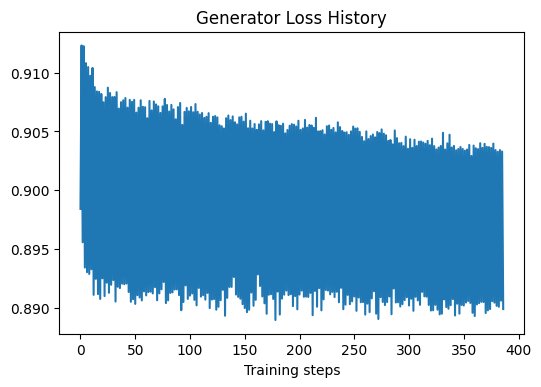

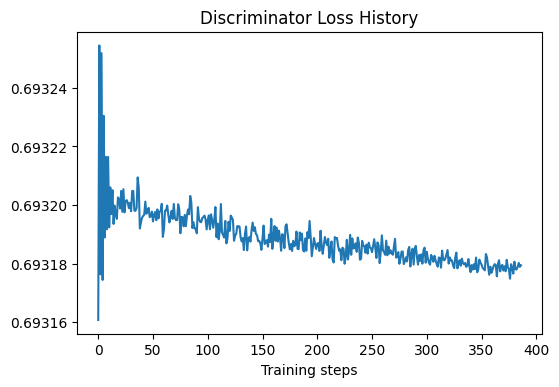

In [22]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

In [26]:
a_exam = generate_sequences(1000, G, BATCH_SIZE, T)

In [27]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
b_exam = generate_sequences(1000, G0,BATCH_SIZE, T)

In [ ]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
if not os.path.exists(model_save_dir + '/G_run_0'):
    os.makedirs(model_save_dir + '/G_run_0')

G_save_path = model_save_dir + '/G_run_0/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_0'):
    os.makedirs(model_save_dir + '/D_run_0')

D_save_path = model_save_dir + '/D_run_0/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Debug

In [ ]:
example_a = tf.zeros((64, 21, 1), dtype=tf.float32)

In [ ]:
rollout_returns = []
for _ in range(10):
    rollout_returns.append(D(example_a))

In [ ]:
tf.reduce_mean(rollout_returns, axis=0).shape

In [ ]:
logits = np.array([1.,2.,-1.]).reshape((1,3))
probs = tf.nn.softmax(logits)

In [ ]:
tf.random.categorical(logits,100)

In [ ]:
aa = tf.reshape(tf.math.log(probs), (1,3))
aa

In [ ]:
tf.random.categorical(aa,100)